In [1]:
%cd -q ../..

In [ ]:
import json
from collections import Counter, defaultdict
from datetime import date
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from scotus_metalang.diachronic_analysis import analysis, authors

In [2]:
model_name = "binary_token_model_bert_large_8_epochs"

### Read prediction data


In [3]:
rows = []
prediction_counts = {}  # Nested dict: author, year, category
token_counts = {}  # Nested dict: author, year
#conservative_justices = [x for x in authors.JUSTICE_TO_IDEOLOGY if authors.JUSTICE_TO_IDEOLOGY[x] == "liberal"]
for author in authors.ORDERED_JUSTICES:
    author_prediction_counts = defaultdict(lambda: {"ft": 0, "mc": 0, "dq": 0, "les": 0})
    author_token_counts = Counter()
    for opinion_path in Path(f"data/cap/known_authors/{author}").glob("*.json"):
        with open(opinion_path, "r") as f:
            case = json.load(f)
            decision_date = date(*[int(_) for _ in case["decision_date"].split("-")])
            opinion_type = case["opinion_type"]
        year = analysis.get_term_year(decision_date)
        docket_number = opinion_path.stem
        filename = opinion_path.stem + ".txt"
        prediction_path = Path("predictions", author, filename)
        scores = np.loadtxt(prediction_path)
        threshold = .5
        num_tokens = len(scores)
        predictions = scores > threshold
        ft, mc, dq, les = np.sum(predictions, axis=0)
        row = [docket_number, author, opinion_type, decision_date, year, num_tokens, ft, mc, dq, les]
        rows.append(row)
columns = ["docket_number", "author", "opinion_type", "decision_date", "term", "tokens", "ft", "mc", "dq", "les"]
df_all = pd.DataFrame(rows, columns=columns)
df_18 = df_all[df_all["term"] < 2019]  # Exclude 2019 data because that's training data
df_18.head()

,docket_number,author,opinion_type,decision_date,term,tokens,ft,mc,dq,les
0,87-328,brennan,majority,1988-06-29,1987,7856,9,22,694,1040
1,87-5765,brennan,dissent,1989-06-26,1988,10221,0,4,1176,2156
2,87-499,brennan,majority,1988-06-17,1987,7192,0,13,1215,1645
3,85-1259,brennan,majority,1987-04-28,1986,6133,3,8,829,1286
4,86-492,brennan,dissent,1988-06-27,1987,7256,0,3,961,1519


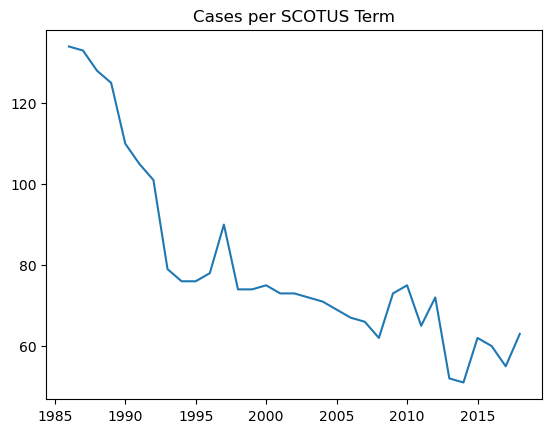

In [4]:
def plot_cases_per_term(df):
    cases_per_term = dict(df.groupby('term')["docket_number"].nunique())
    plt.plot(cases_per_term.keys(), cases_per_term.values())
    title = "Cases per SCOTUS Term"
    plt.title(title)
    plt.savefig(f"figures/{title}.pdf")
    plt.show()
plot_cases_per_term(df_18)

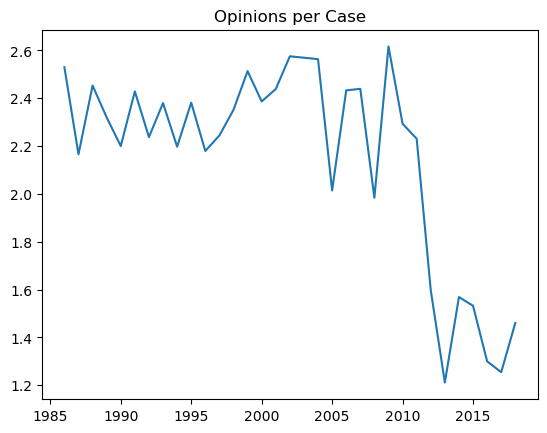

In [5]:
def plot_avg_opinions_per_case(df):
    cases_per_term = dict(df.groupby('term')["docket_number"].nunique())
    opinions_per_term = dict(df.groupby("term").size())
    average_per_term = [opinions_per_term[term] / cases_per_term[term] for term in cases_per_term]
    plt.plot(cases_per_term.keys(), average_per_term)
    title = "Opinions per Case"
    plt.title(title)
    plt.savefig(f"figures/{title}.pdf")
    plt.show()
plot_avg_opinions_per_case(df_18)

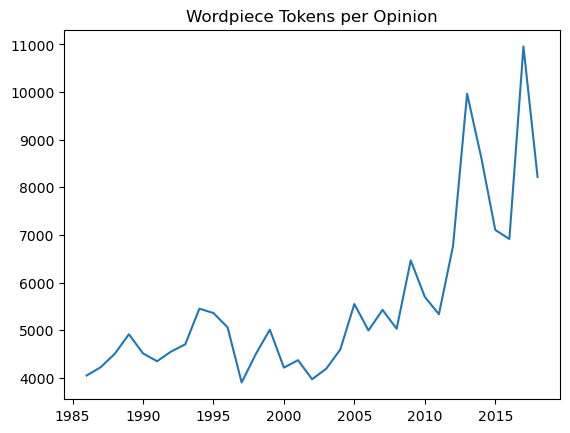

In [6]:
def plot_opinion_length_per_term(df):
    tokens_per_term = dict(df.groupby("term")["tokens"].mean())
    plt.plot(tokens_per_term.keys(), tokens_per_term.values())
    title = "Wordpiece Tokens per Opinion"
    plt.title(title)
    plt.savefig(f"figures/{title}.pdf")
    plt.show()
plot_opinion_length_per_term(df_18)

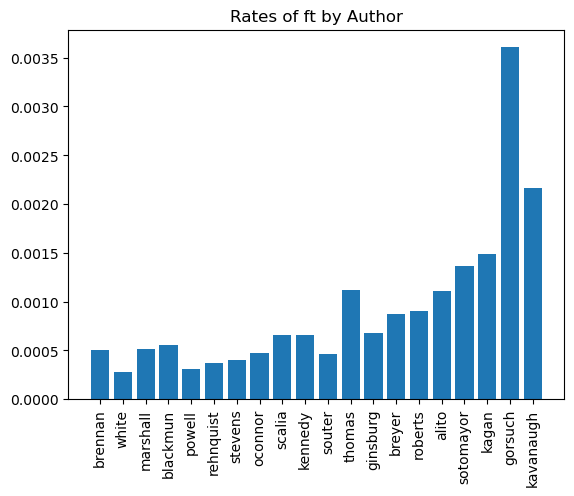

In [7]:
def plot_frequency_by_author(category, df):
    cat_by_author = dict(df.groupby(['author'])[category].sum())
    tokens_by_author = dict(df.groupby(['author'])["tokens"].sum())
    frequencies_by_author = [cat_by_author[a] / tokens_by_author[a] for a in authors.ORDERED_JUSTICES]
    plt.xticks(rotation=90)
    plt.bar(authors.ORDERED_JUSTICES.keys(), frequencies_by_author)
    title = f"Rates of {category} by Author"
    plt.title(title)
    plt.savefig(f"figures/{title}.pdf")
    plt.show()
plot_frequency_by_author("ft", df_18)

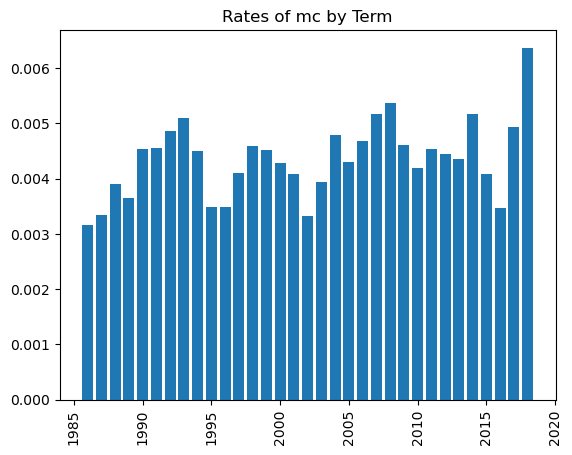

In [8]:
def plot_frequency_by_term(category, df):
    cat_by_term = dict(df.groupby(["term"])[category].sum())
    tokens_by_term = dict(df.groupby(["term"])["tokens"].sum())
    frequencies_by_term = [cat_by_term[term] / tokens_by_term[term] for term in cat_by_term]
    plt.xticks(rotation=90)
    plt.bar(cat_by_term.keys(), frequencies_by_term)
    title = f"Rates of {category} by Term"
    plt.title(title)
    plt.savefig(f"figures/{title}.pdf")
    plt.show()
plot_frequency_by_term("mc", df_18)

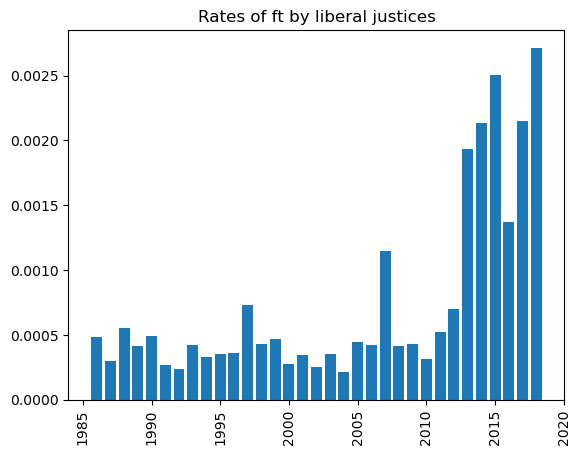

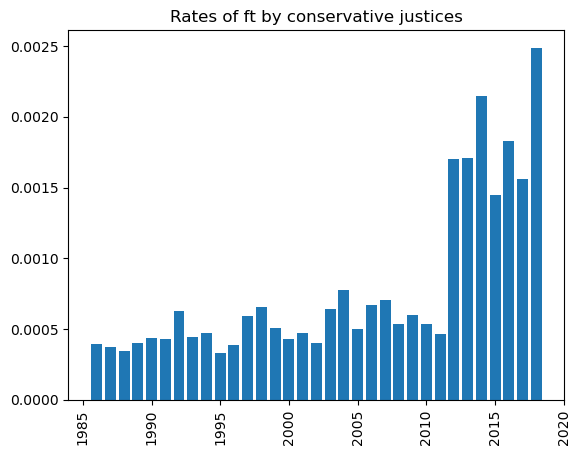

In [9]:
def plot_frequency_by_term_and_ideology(category, ideology, df):
    authors_of_interest = [author for author in authors.JUSTICE_TO_IDEOLOGY
                           if authors.JUSTICE_TO_IDEOLOGY[author] == ideology]
    df_sample = df[df["author"].isin(authors_of_interest)]
    cat_by_term = dict(df_sample.groupby(["term"])[category].sum())
    tokens_by_term = dict(df_sample.groupby(["term"])["tokens"].sum())
    frequencies_by_term = [cat_by_term[term] / tokens_by_term[term] for term in cat_by_term]
    plt.xticks(rotation=90)
    plt.bar(cat_by_term.keys(), frequencies_by_term)
    title = f"Rates of {category} by {ideology} justices"
    plt.title(title)
    plt.savefig(f"figures/{title}.pdf")
    plt.show()
plot_frequency_by_term_and_ideology("ft","liberal", df_18)
plot_frequency_by_term_and_ideology("ft","conservative", df_18)